# Project 4 - West Nile Virus Prediction

## Problem Statement
The intent of this project is to analyze weather data and GIS data and predicting the presence of the West Nile virus, for a given time, location, and species. 

##  General Approach
- [Data cleaning](#Data-Cleaning)
- [Data imputation](#Data-Imputation)
- [Data visualization](#Data-Visualization)
- [Feature selection](#Featuion-Selection)
- [Cross validation](#Cross-Validation)
- [Model fitting](#Model-Fitting)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
# Load dataset 
train = pd.read_csv('assets/train.csv')
test = pd.read_csv('assets/test.csv')
sample = pd.read_csv('assets/sampleSubmission.csv')
weather = pd.read_csv('assets/weather.csv')
spray = pd.read_csv('assets/spray.csv')

### Data Cleaning

#### Cleaning train and test data

In [3]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [5]:
#Define function to get year and month from date
get_year = lambda x:x.split('-')[0]
get_month = lambda x:x.split('-')[1]

In [6]:
# Convert to date time format
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [7]:
#Find Satellite Trap in Train Data
satellite_trap = [t for t in train['Trap'].value_counts().index if len(t) == 5]
satellite_trap

['T054C', 'T094B']

In [8]:
#Find extra categories in Trap in Test data

extra = [t for t in test['Trap'].value_counts().index if t not in train['Trap'].value_counts().index]
extra

['T090A',
 'T065A',
 'T200A',
 'T218C',
 'T218B',
 'T002B',
 'T200B',
 'T234',
 'T090C',
 'T128A',
 'T090B',
 'T002A',
 'T218A']

'T234' is present in df_test['Trap'] but not df_train['Trap']

In [9]:
#convert all satellite trap to have the same trap name as parent trap
trap_rename = lambda x: x[0:4] if len(x)==5 else x
train['Trap'] = train['Trap'].apply(trap_rename)
test['Trap'] = test['Trap'].apply(trap_rename)

In [10]:
#Remove T in Trap name
remove_t = lambda x: x.replace('T','')
train['Trap'] = train['Trap'].apply(remove_t)
test['Trap'] = test['Trap'].apply(remove_t)

#Convert Trap type to int
train['Trap'] = train['Trap'].astype('int64')
test['Trap'] = test['Trap'].astype('int64')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null int64
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 985.1+ KB


In [12]:
#Each row only has maximum 50 mosquito before a new row is created, need to sum up the total mosquito by species,
#trap,date and WnvPresent
train.groupby(['Date', 'Trap', 'Species','WnvPresent'], as_index=False)['NumMosquitos'].sum().sort_values(by='NumMosquitos')


,Date,Trap,Species,WnvPresent,NumMosquitos
0,2007-05-29,2,CULEX PIPIENS/RESTUANS,0,1
4642,2009-09-25,128,CULEX PIPIENS,0,1
1806,2007-08-24,34,CULEX PIPIENS,0,1
4639,2009-09-25,115,CULEX PIPIENS,0,1
4638,2009-09-25,114,CULEX PIPIENS/RESTUANS,0,1
...,...,...,...,...,...
860,2007-08-01,115,CULEX PIPIENS,0,1543
1220,2007-08-08,138,CULEX PIPIENS,0,1558
1481,2007-08-16,115,CULEX PIPIENS,0,2050
1954,2007-08-28,115,CULEX PIPIENS,0,2107


In [13]:
#merge total mosquito with train data
train = pd.merge(train, train.groupby(['Date', 'Trap', 'Species','WnvPresent'], as_index=False)['NumMosquitos'].sum(), 
                    how='left', on=['Date', 'Trap', 'Species','WnvPresent'])
#rename column wich include total mosquito
train.columns = ['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent','Tot_Mos_Species']
train.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Tot_Mos_Species
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,1


In [14]:
train = train[train.duplicated(subset=['Date', 'Trap', 'Species','Tot_Mos_Species','WnvPresent']) == False]
len(train)

8599

In [15]:
# remove redundant species name
train['Species'] = train['Species'].apply(lambda x:x.replace('CULEX',''))
test['Species'] = test['Species'].apply(lambda x:x.replace('CULEX',''))

In [16]:
# Grouping minority species as others 
train[['Species','WnvPresent']].groupby('Species').count()

,WnvPresent
Species,
ERRATICUS,1
PIPIENS,1994
PIPIENS/RESTUANS,3893
RESTUANS,2406
SALINARIUS,83
TARSALIS,6
TERRITANS,216


In [17]:
# Grouping minority species as others 

others = [' ERRATICUS',' SALINARIUS',' TARSALIS',' TERRITANS']
train['Species'] = train['Species'].apply(lambda x: 'Others' if x in others else x.replace(' ',''))
test['Species'] = test['Species'].apply(lambda x: 'Others' if x in others else x.replace(' ',''))

#### Cleaning Spray data

#### Cleaning Weather data.
We will look through the weather dataset to see if we can reasonably fill the missing values and drop columns which we feel are less or not relevant to help us predict the presence of the mosquito or virus.

In [18]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [19]:
weather_cols_drop = ['Depart', 'SunRise', 'SunSet', 'Depth', 'Water1', 'SnowFall', 'Heat', 'Cool']

In [20]:
# looking at the data types
weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

Some observations from looking at the weather types
- 'Tavg' should have a daya type of integer or float since it is the average of 2 integers ('Tmax' and 'Tmin'). 
- Features like 'Depart', 'Sunrise', 'Sunset', 'Depth', 'Water1', 'Snowfall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed' should also be either integer or float. 

In [21]:
# checking the values for 'Depart'
weather[weather['Depart'] == 'M'].head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [22]:
# we will be dropping 'Depart' as all 'Depart' entries are missing from Station 2
weather.drop(columns='Depart', inplace=True)

In [23]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,51,56,0,2,0448,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,51,57,0,3,-,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,42,47,14,0,0447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,42,47,13,0,-,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,40,48,9,0,0446,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [24]:
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: '0.00' if 'M' in x else x)
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: '0.00' if 'T' in x else x)

In [25]:
# convert to floating dtype
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

In [26]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,51,56,0,2,0448,...,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,51,57,0,3,-,...,,M,M,M,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,42,47,14,0,0447,...,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,42,47,13,0,-,...,BR HZ,M,M,M,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,40,48,9,0,0446,...,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9


In [27]:
# obtaining Tavg from Tmin and Tmax
weather['Tavg'] = np.round(((weather['Tmax']+ weather['Tmin']) + 1)/2)
weather['Tavg'] = weather['Tavg'].astype(int)

In [28]:
weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg             int64
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal    float64
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

In [29]:
M_index = weather[weather['AvgSpeed'] == 'M']['AvgSpeed'].index


In [30]:
weather.loc[M_index, 'AvgSpeed'] = np.nan

In [31]:
weather['AvgSpeed'].fillna(weather[['AvgSpeed']].mean())

0        9.2
1        9.6
2       13.4
3       13.4
4       11.9
        ... 
2939     9.0
2940     5.5
2941     6.5
2942    22.9
2943    22.6
Name: AvgSpeed, Length: 2944, dtype: object

In [32]:
weather['AvgSpeed'].value_counts()

6.9     63
5.8     60
7.4     55
8.1     49
7.0     47
        ..
16.2     1
18.5     1
26.3     1
22.6     1
16.9     1
Name: AvgSpeed, Length: 177, dtype: int64

In [33]:
weather['AvgSpeed'] = weather['AvgSpeed'].astype(float)

In [34]:
weather_cols_drop = ['Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall']

In [35]:
weather.drop(columns=weather_cols_drop, inplace=True)

In [36]:
weather['Date'] = pd.to_datetime(weather['Date'])

In [37]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                    int64
DewPoint                int64
WetBulb                object
Heat                   object
Cool                   object
CodeSum                object
PrecipTotal           float64
StnPressure            object
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
dtype: object

In [38]:
# since the value of DewPoint is similar for both stations on the same day, 
# we will replace the missing values with values from the same day. 
weather.loc[[848, 849, 2410, 2411, 2412, 2413, 2414, 2415], :]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
848,1,2009-06-26,86,69,78,60,M,0,13,,0.00,M,29.85,6.4,4,8.2
849,2,2009-06-26,86,72,80,61,67,0,14,,0.00,29.20,29.83,6.4,4,8.0
2410,1,2013-08-10,81,64,73,57,M,0,8,,0.00,M,30.08,5.3,5,6.5
2411,2,2013-08-10,81,68,75,55,63,0,10,,0.00,M,30.07,6.0,6,7.4
2412,1,2013-08-11,81,60,71,61,M,0,6,RA,0.01,29.35,30.07,2.0,27,3.0
2413,2,2013-08-11,84,63,74,57,64,0,9,,0.00,29.42,30.06,4.0,24,5.4
2414,1,2013-08-12,82,67,75,65,68,0,10,RA DZ,0.27,29.21,29.93,3.5,27,7.5
2415,2,2013-08-12,85,69,78,63,M,0,12,RA,0.66,29.27,29.92,4.5,26,7.7


In [39]:
# replace the values accordingly, converting series to int
weather.at[848, 'WetBulb'] = weather.at[849, 'WetBulb'] 
weather.at[2410, 'WetBulb'] = weather.at[2411, 'WetBulb'] 
weather.at[2412, 'WetBulb'] = weather.at[2413, 'WetBulb'] 
weather.at[2415, 'WetBulb'] = weather.at[2414, 'WetBulb'] 
weather['WetBulb'] = weather['WetBulb'].astype(int);

In [40]:
# verifying the change
weather.loc[[848, 849, 2410, 2411, 2412, 2413, 2414, 2415], :]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
848,1,2009-06-26,86,69,78,60,67,0,13,,0.00,M,29.85,6.4,4,8.2
849,2,2009-06-26,86,72,80,61,67,0,14,,0.00,29.20,29.83,6.4,4,8.0
2410,1,2013-08-10,81,64,73,57,63,0,8,,0.00,M,30.08,5.3,5,6.5
2411,2,2013-08-10,81,68,75,55,63,0,10,,0.00,M,30.07,6.0,6,7.4
2412,1,2013-08-11,81,60,71,61,64,0,6,RA,0.01,29.35,30.07,2.0,27,3.0
2413,2,2013-08-11,84,63,74,57,64,0,9,,0.00,29.42,30.06,4.0,24,5.4
2414,1,2013-08-12,82,67,75,65,68,0,10,RA DZ,0.27,29.21,29.93,3.5,27,7.5
2415,2,2013-08-12,85,69,78,63,68,0,12,RA,0.66,29.27,29.92,4.5,26,7.7


In [41]:
# looking through 'Heat'
weather['Heat'].value_counts()

0     1870
4       88
1       86
2       81
8       67
3       66
5       61
15      57
7       49
12      49
11      48
10      48
13      46
9       46
6       45
14      36
16      29
20      28
18      24
19      24
21      19
17      17
23      15
22      12
M       11
24       7
25       5
26       4
29       2
28       2
27       2
Name: Heat, dtype: int64

In [42]:
# looking through 'Cool'
weather['Cool'].value_counts()

 0    1147
 8     138
 5     117
12     117
10     110
 6     109
 9     107
 7     104
 4     103
13     102
11     100
 3      99
14      98
 1      93
 2      89
15      84
16      55
17      48
18      34
19      21
21      16
20      16
M       11
22       9
26       4
23       4
24       4
25       2
29       1
27       1
28       1
Name: Cool, dtype: int64

In [43]:
# we will drop both 'Heat' and 'Cool' as their values are mostly skewed to 0 
weather = weather.drop(columns=['Heat', 'Cool'])

In [44]:
# since the value of StnPressure is similar for both stations on the same day, 
# we will replace the missing values with values from the same day. 
# we will replace the rows 2410 and 2411 with the column mean as both stations have missing data
weather.loc[[86, 87, 848, 849, 2410, 2411], :]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
86,1,2007-06-13,87,60,74,53,62,,0.0,29.36,30.09,7.2,5,8.6
87,2,2007-06-13,86,68,78,53,62,,0.0,M,M,7.0,5,NaN
848,1,2009-06-26,86,69,78,60,67,,0.0,M,29.85,6.4,4,8.2
849,2,2009-06-26,86,72,80,61,67,,0.0,29.20,29.83,6.4,4,8.0
2410,1,2013-08-10,81,64,73,57,63,,0.0,M,30.08,5.3,5,6.5
2411,2,2013-08-10,81,68,75,55,63,,0.0,M,30.07,6.0,6,7.4


In [45]:
# replace the values accordingly, converting series to float
weather.at[87, 'StnPressure'] = weather.at[86, 'StnPressure'] 
weather.at[848, 'StnPressure'] = weather.at[849, 'StnPressure']
weather.at[2410, 'StnPressure'] = np.nan
weather.at[2411, 'StnPressure'] = np.nan
weather['StnPressure'].fillna(weather['StnPressure'].astype(float).mean(), inplace=True)
weather['StnPressure'] = weather['StnPressure'].astype(float);

In [46]:
# verifying the change
weather.loc[[86, 87, 848, 849, 2410, 2411], :]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
86,1,2007-06-13,87,60,74,53,62,,0.0,29.360000,30.09,7.2,5,8.6
87,2,2007-06-13,86,68,78,53,62,,0.0,29.360000,M,7.0,5,NaN
848,1,2009-06-26,86,69,78,60,67,,0.0,29.200000,29.85,6.4,4,8.2
849,2,2009-06-26,86,72,80,61,67,,0.0,29.200000,29.83,6.4,4,8.0
2410,1,2013-08-10,81,64,73,57,63,,0.0,29.284426,30.08,5.3,5,6.5
2411,2,2013-08-10,81,68,75,55,63,,0.0,29.284426,30.07,6.0,6,7.4


In [47]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                    int64
DewPoint                int64
WetBulb                 int64
CodeSum                object
PrecipTotal           float64
StnPressure           float64
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
dtype: object

In [48]:
# since the value of SeaLevel is similar for both stations on the same day, 
# we will replace the missing values with values from the same day. 
weather.loc[[86, 87, 832, 833, 994, 995, 1732, 1733, 1744, 1745, 1756, 1757, 2066, 2067, 2090, 2091, 2742, 2743], :]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
86,1,2007-06-13,87,60,74,53,62,,0.00,29.36,30.09,7.2,5,8.6
87,2,2007-06-13,86,68,78,53,62,,0.00,29.36,M,7.0,5,NaN
832,1,2009-06-18,80,61,71,63,67,RA BR,0.12,29.08,M,6.7,16,7.9
833,2,2009-06-18,81,63,72,64,67,TSRA BR HZ,0.11,29.15,29.79,3.7,17,5.8
994,1,2009-09-07,77,59,68,59,62,BR,0.00,29.39,M,5.8,3,4.0
995,2,2009-09-07,77,63,70,59,63,BR HZ,0.00,29.44,30.09,6.3,4,6.9
1732,1,2011-09-08,75,57,66,53,59,RA,0.00,29.34,M,13.0,2,13.4
1733,2,2011-09-08,74,62,68,54,59,RA DZ BR,0.06,29.36,30.03,14.9,2,15.2
1744,1,2011-09-14,58,47,53,43,49,RA BR HZ FU,0.08,29.39,30.09,6.3,34,7.3
1745,2,2011-09-14,60,48,54,45,51,RA BR HZ FU,0.00,29.47,M,6.0,32,NaN


In [49]:
# replace the values accordingly, converting series to float
weather.at[87, 'SeaLevel'] = weather.at[86, 'SeaLevel'] 
weather.at[832, 'SeaLevel'] = weather.at[833, 'SeaLevel'] 
weather.at[994, 'SeaLevel'] = weather.at[995, 'SeaLevel']
weather.at[1732, 'SeaLevel'] = weather.at[1733, 'SeaLevel'] 
weather.at[1745, 'SeaLevel'] = weather.at[1744, 'SeaLevel'] 
weather.at[1756, 'SeaLevel'] = weather.at[1757, 'SeaLevel'] 
weather.at[2067, 'SeaLevel'] = weather.at[2066, 'SeaLevel'] 
weather.at[2090, 'SeaLevel'] = weather.at[2091, 'SeaLevel'] 
weather.at[2743, 'SeaLevel'] = weather.at[2742, 'SeaLevel'] 
weather['SeaLevel'] = weather['SeaLevel'].astype(float);

In [50]:
# verifying the change
weather.loc[[86, 87, 832, 833, 994, 995, 1732, 1733, 1744, 1745, 1756, 1757, 2066, 2067, 2090, 2091, 2742, 2743], :]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
86,1,2007-06-13,87,60,74,53,62,,0.00,29.36,30.09,7.2,5,8.6
87,2,2007-06-13,86,68,78,53,62,,0.00,29.36,30.09,7.0,5,NaN
832,1,2009-06-18,80,61,71,63,67,RA BR,0.12,29.08,29.79,6.7,16,7.9
833,2,2009-06-18,81,63,72,64,67,TSRA BR HZ,0.11,29.15,29.79,3.7,17,5.8
994,1,2009-09-07,77,59,68,59,62,BR,0.00,29.39,30.09,5.8,3,4.0
995,2,2009-09-07,77,63,70,59,63,BR HZ,0.00,29.44,30.09,6.3,4,6.9
1732,1,2011-09-08,75,57,66,53,59,RA,0.00,29.34,30.03,13.0,2,13.4
1733,2,2011-09-08,74,62,68,54,59,RA DZ BR,0.06,29.36,30.03,14.9,2,15.2
1744,1,2011-09-14,58,47,53,43,49,RA BR HZ FU,0.08,29.39,30.09,6.3,34,7.3
1745,2,2011-09-14,60,48,54,45,51,RA BR HZ FU,0.00,29.47,30.09,6.0,32,NaN


In [51]:
# since precipitation seems promotes breeding of mosquitos we will check for 'RA/DZ/TS' for occurance of rain
# we will create another column, 'Rain' and indicate 1 for 'RA/DZ/TS' and 0 for other codes
weather['Rain'] = weather['CodeSum'].apply(lambda x : 1 if 'RA' in x else (1 if 'DZ' in x else (1 if 'TS' in x else 0)))

In [52]:
# we will then drop 'CodeSum'
weather.drop(columns='CodeSum', inplace=True)

In [53]:
# verifying columns and datatypes
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                    int64
DewPoint                int64
WetBulb                 int64
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
Rain                    int64
dtype: object

#### Merging weather data to train/test data

In [54]:
def closest_point(point):
    station1, station2 = [41.995, -87.933], [41.786, -87.752]  # Fixed coordinates for two stations
    points = [station1, station2] 
    if cdist([point], points).argmin() == 0: return 1 # return index of closest point
    return 2

In [55]:
# Assign Station to train data based on station coordinates
train['Station'] = [closest_point(x) for x in train[['Latitude','Longitude']].values]
test['Station'] = [closest_point(x) for x in test[['Latitude','Longitude']].values]

In [56]:
# Merge weather data to train data base on date and station number
train = train.merge(weather, on=['Date','Station'])
test = test.merge(weather, on=['Date','Station'])

In [57]:
train.

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                               int64
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
Tot_Mos_Species                    int64
Station                            int64
Tmax                               int64
Tmin                               int64
Tavg                               int64
DewPoint                           int64
WetBulb                            int64
PrecipTotal                      float64
StnPressure                      float64
SeaLevel                         float64
ResultSpeed                      float64
ResultDir                          int64
AvgSpeed        

#### Merging spray data to train/test data

### Data Visualization

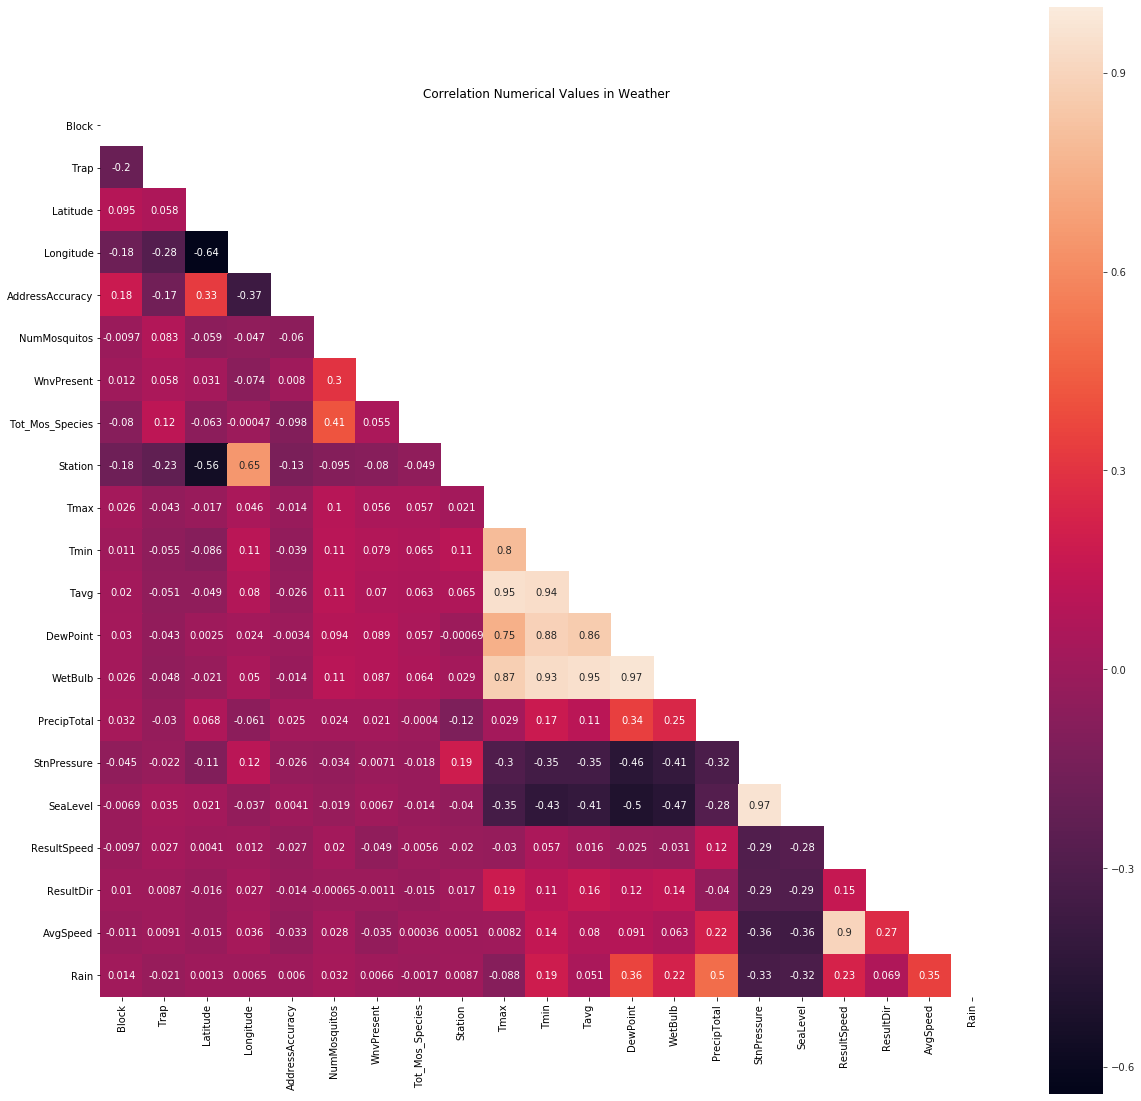

In [62]:
#establish figure size
plt.figure(figsize=(20,20))

#setting title
ax = plt.axes()
ax.set_title('Correlation Numerical Values in Weather')

#set up mask to be "True" in the upper triangle
mask = np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)] = True

#plotting heatmap while masking upper triangle with white
with sns.axes_style("white"):
    sns.heatmap(train.corr(), mask=mask, square = True, annot=True)

### Feature Selection

### Cross Validation

### Model Fitting